In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sensitivity_tests import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import os

from gurobipy import *
setParam("OutputFlag", 0)

Academic license - for non-commercial use only


In [3]:
# Ranking Algorithms
colley = ColleyRankingAlgorithm()
massey = MasseyRankingAlgorithm()
lop_alg = LOPRankingAlgorithm()

# Rankability Metric
rankability_metrics = [KendallWMetric(), MeanTauMetric(), L2DifferenceMetric()]
metric_names = ["KendallW", "MeanTau", "L2Difference"]

# Noise Generator
swapNoiseGen = SwapNoise(noisePercentage=0.05)

In [4]:
ELO_var = [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
n_instances = 20
n_trials = 2
n_items = 16

lop_taus = []
lop_rs = {}
massey_taus = []
massey_rs = {}
colley_taus = []
colley_rs = {}

for name in metric_names:
    lop_rs[name] = []
    massey_rs[name] = []
    colley_rs[name] = []

for var in tqdm(ELO_var):
    data_source = SynthELOTournamentSource(16, n_games=100, comp_var=var)
    for instance_idx in range(n_instances):
        inst = ProblemInstance(data_source, swapNoiseGen)
        rs, taus = inst.get_sensitivity(lop_alg, rankability_metrics, n_trials=n_trials, progress_bar=False)
        lop_taus.extend(taus)
        for r_idx in range(len(rs)):
            lop_rs[metric_names[r_idx]].extend([rs[r_idx]]*n_trials)
        rs, taus = inst.get_sensitivity(massey, rankability_metrics, n_trials=n_trials, progress_bar=False)
        massey_taus.extend(taus)
        for r_idx in range(len(rs)):
            massey_rs[metric_names[r_idx]].extend([rs[r_idx]]*n_trials)
        rs, taus = inst.get_sensitivity(colley, rankability_metrics, n_trials=n_trials, progress_bar=False)
        colley_taus.extend(taus)
        for r_idx in range(len(rs)):
            colley_rs[metric_names[r_idx]].extend([rs[r_idx]]*n_trials)

100%|██████████| 11/11 [06:10<00:00, 33.69s/it]


In [5]:
def plot_taus(rankability_vals, taus, method_name, scatter_alpha=0.01, histogram_bins=30, save_dir="rankability_figures"):
    # Create directory for saving if specified
    saving = False
    if save_dir is not None and save_dir != "":
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        saving = True
    
    # Plot scatter plot
    plt.scatter(rankability_vals, taus, alpha=scatter_alpha)
    title = "%s Sensitivity Scatter" % method_name
    plt.title(title)
    plt.xlabel('Rankability')
    plt.xlim(0.0, 1.0)
    plt.ylabel('Tau')
    plt.ylim(-1.0, 1.0)
    if saving:
        save_path = os.path.join(save_dir, title.replace(" ", "_") + ".png")
        plt.savefig(save_path)
    plt.show()
    
    # Plot 2D Histogram
    plt.hist2d(rankability_vals, taus, bins=histogram_bins, range=[[0.0, 1.0], [-1.0, 1.0]])
    title = "%s Sensitivity Histogram" % method_name
    plt.title(title)
    plt.xlabel('Rankability')
    plt.ylabel('Tau')
    if saving:
        save_path = os.path.join(save_dir, title.replace(" ", "_") + ".png")
        plt.savefig(save_path)
    plt.show()

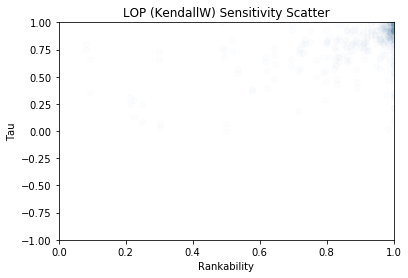

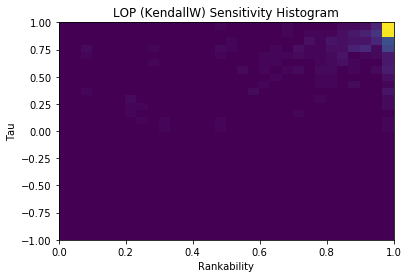

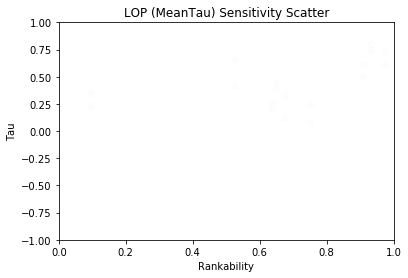

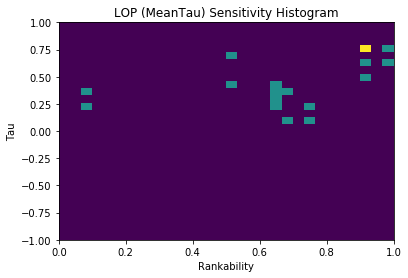

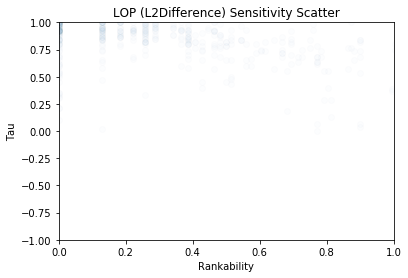

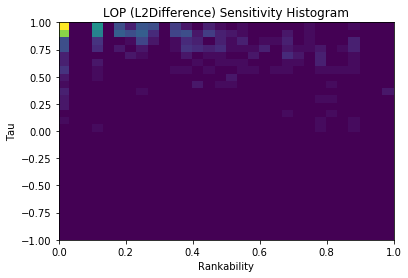

In [7]:
for metric_name in metric_names:
    plot_taus(lop_rs[metric_name], lop_taus, "LOP (%s)" % metric_name)

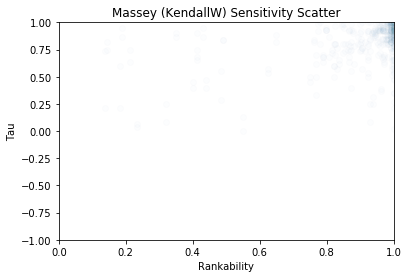

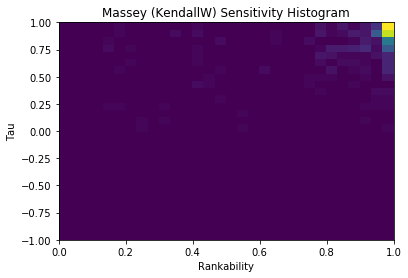

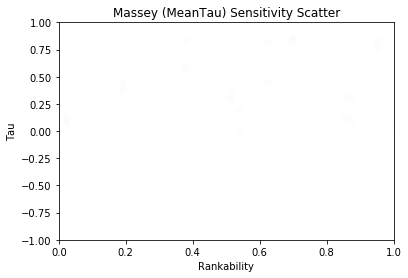

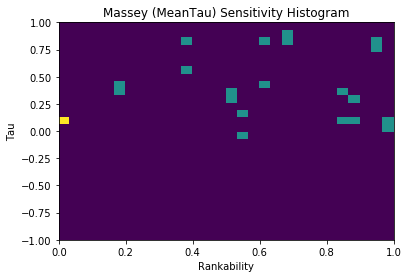

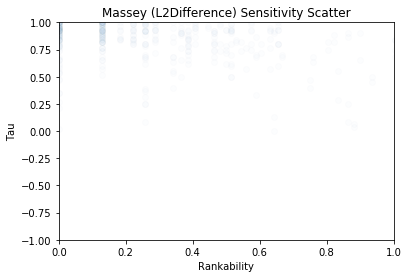

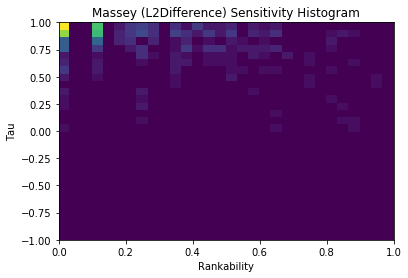

In [8]:
for metric_name in metric_names:
    plot_taus(massey_rs[metric_name], lop_taus, "Massey (%s)" % metric_name)

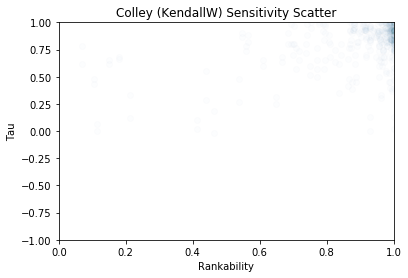

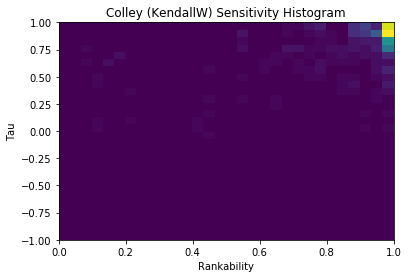

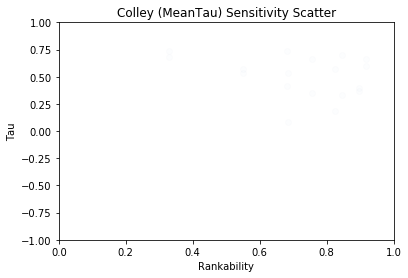

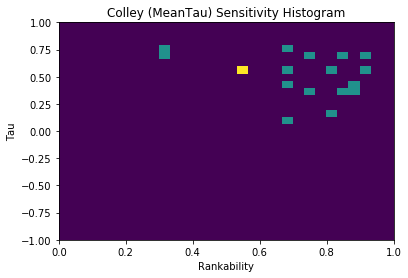

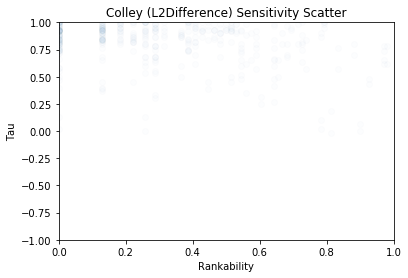

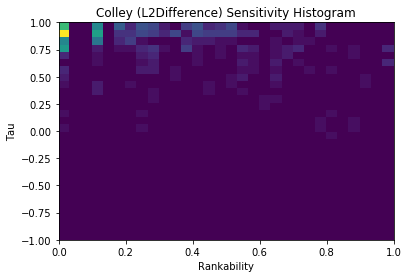

In [9]:
for metric_name in metric_names:
    plot_taus(colley_rs[metric_name], lop_taus, "Colley (%s)" % metric_name)

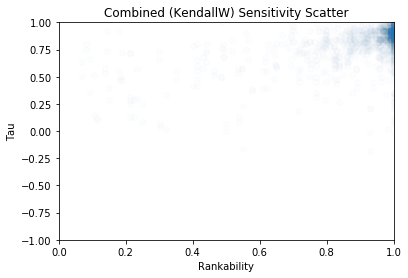

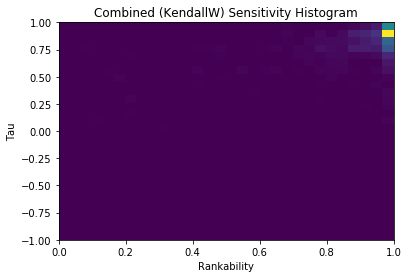

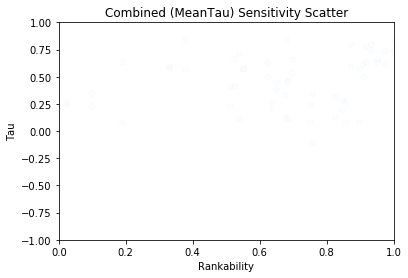

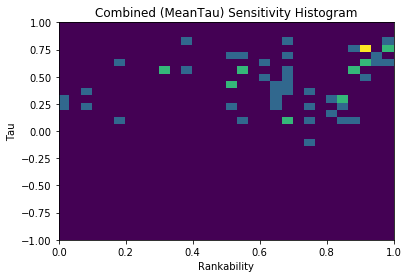

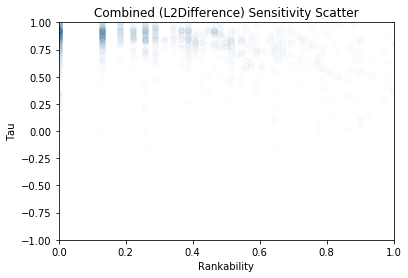

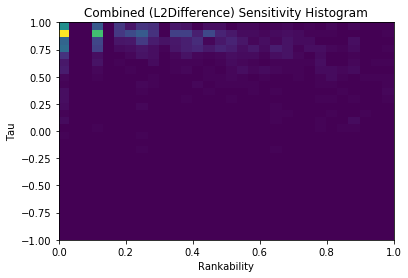

In [10]:
combined_taus = lop_taus + massey_taus + colley_taus
for metric_name in metric_names:
    combined_rs = lop_rs[metric_name] + massey_rs[metric_name] + colley_rs[metric_name]
    plot_taus(combined_rs, combined_taus, "Combined (%s)" % metric_name)